In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import functions as fxn
from astropy.table import Table
from astropy import units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky

## loading files 

In [2]:
# All master objects with idp values

cone = pd.read_csv('/home/alok/Documents/GAIAproject/DR3/cone.csv')
cone["ABSmag"] = cone['GAIAG'] + (5*np.log10(cone['PARALLAX']/100.))
cone["GAIA_GR"] = cone['GAIAG'] - cone['GAIARP']
cone['G_K'] = cone['GAIAG'] - cone['TMASSK']

/home/alok/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [3]:
# Gaia and Tmass isochrone values
gaia = pd.read_csv("/home/alok/isochrones.csv")
gaia = gaia.drop(['Unnamed: 0'], axis=1)
tmass = pd.read_csv("/home/alok/tmass.csv")
tmass = tmass.drop(['Unnamed: 0'], axis=1)

In [4]:

master = pd.read_csv('Master_withDR3.csv')
print(len(cone),len(master))

11369 14279


In [7]:
primary = pd.read_csv('Primary_matches.csv')
primary_basic = pd.read_csv('primary_inbasic.csv') 
secondary_basic = pd.read_csv('secondary_inbasic.csv')

In [8]:
def Converttolist(string): 
    string_list = list(string.split(";")) 
    string_list = [a.strip() for a in string_list ]
    return string_list


primary_sec = []
for i in range(len(secondary_basic)):
    
    for j in range(len(primary)):
        compan = Converttolist(primary.iloc[j]['COMPANIONS'])
        
        if secondary_basic.iloc[i]['SHORTNAME'].strip() in compan:
            primary_sec.append(primary.iloc[j][:])
            continue

In [9]:
primary_in_basic= []
for i in range(len(primary_basic)):
    for j in range(len(primary)):
        if primary.iloc[j]['SHORTNAME'].strip() == primary_basic.iloc[i]['SHORTNAME'].strip():
            primary_in_basic.append(primary.iloc[j][:])
            continue

In [10]:
all_in_basic = primary_sec + primary_in_basic
basic = pd.DataFrame(all_in_basic, columns = list(primary.columns))
basic = basic.drop(['Unnamed: 0'], axis =1)
basic["ABSmag"] = basic['GAIAG'] + (5*np.log10(basic['PARALLAX']/100.))
basic["GAIA_GR"] = basic['GAIAG'] - basic['GAIARP']
basic['G_K'] = basic['GAIAG'] - basic['TMASSK']

## Making list of secondaries

In [11]:
second = []
for i in range(len(basic)):
    sec_obj = Converttolist(basic.iloc[i]['COMPANIONS'])
    for j in range(len(master)):
        if master.iloc[j]['SHORTNAME'].strip() in sec_obj:
            second.append(master.iloc[j][:])
            continue

[SHORTNAME                         J2354-3316A
 DISCOVERYNAME         GDR22313836325604479616
 DISCOVERYREFNAME          ...................
 RA                                    358.503
 DEC                                  -33.2771
                                ...           
 RA2016                                358.503
 DEC2016                              -33.2771
 LITPARALLAX                            -99999
 LITPARALLAXERR                         -99999
 LITPARALLAXREFNAME        ...................
 Name: 14241, Length: 114, dtype: object,
 SHORTNAME                      J2354-3316
 DISCOVERYNAME            APMPMJ2354-3316C
 DISCOVERYREFNAME      ...................
 RA                                358.537
 DEC                              -33.2759
                              ...         
 RA2016                            358.537
 DEC2016                          -33.2759
 LITPARALLAX                        -99999
 LITPARALLAXERR                     -99999
 LITPARALLA

In [12]:
only_secondary = pd.DataFrame(second, columns= list(master.columns))

In [13]:
only_secondary = only_secondary.reset_index(drop=True)
only_secondary["ABSmag"] = only_secondary['GAIAG'] + (5*np.log10(only_secondary['PARALLAX']/100.))
only_secondary["GAIA_GR"] = only_secondary['GAIAG'] - only_secondary['GAIARP']
only_secondary['G_K'] = only_secondary['GAIAG'] - only_secondary['TMASSK']

In [14]:
gaia = gaia[["M/Ms",'G', 'G_RP','t(Gyrs)']]
tmass = tmass[["M/Ms",'Mj','Mk','Mh','t(Gyrs)']]
gaia = gaia[gaia['t(Gyrs)'] < 0.08]
tmass = tmass[tmass['t(Gyrs)']< 0.08]
time = list(set(gaia['t(Gyrs)']))
print(time)

[0.015, 0.03, 0.05, 0.01, 0.008, 0.025, 0.04, 0.005, 0.02, 0.004, 0.003, 0.002, 0.001, 0.0005]


In [15]:
len(basic[basic['G_K'] > - 0.6])

157

In [24]:
pri=[]
sec =[]

for t in time:
    gaia_age = gaia[gaia['t(Gyrs)'] == t]
    gaia_age = gaia_age.drop(['t(Gyrs)'], axis = 1)
    tmass_age = tmass[tmass['t(Gyrs)'] == t]
    tmass_age = tmass_age.drop(['t(Gyrs)'], axis = 1)
    data = gaia_age.join(tmass_age.set_index("M/Ms"), on= 'M/Ms')
    data = data.dropna()
    data['G_K'] = data['G']- data['Mk']

    object_A = []
    object_B= []
    for i in range(len(data)):
        g = data.iloc[i]['G']
        gk = data.iloc[i]['G_K']
        filter = basic['ABSmag'] > g-1.1
        filter &= basic['ABSmag'] < g+1.1
        filter &= basic['G_K'] > gk-0.21
        filter &= basic['G_K'] < gk+ 0.21
        filtered_obj = basic[filter]
        if len(filtered_obj) == 0:
            continue
        else:
            object_A.append(filtered_obj[:][:])

    for i in range(len(data)):
        g = data.iloc[i]['G']
        gk = data.iloc[i]['G_K']
        filter = only_secondary['ABSmag'] > g-1.1
        filter &= only_secondary['ABSmag'] < g+ 1.1
        filter &= only_secondary['G_K'] > gk-0.21
        filter &= only_secondary['G_K'] < gk+ 0.21
        filtered_obj = only_secondary[filter]
        if len(filtered_obj) == 0:
            continue
        else:
            object_B.append(filtered_obj[:][:])
    if len(object_A)>0 and len(object_B)>0:
        obj_A = [object_A[i].values[0] for i in range(len(object_A))]
        object_A = pd.DataFrame(obj_A, columns=list(basic.columns))
        obj_B = [object_B[i].values[0] for i in range(len(object_B))]
        object_B = pd.DataFrame(obj_B, columns=list(only_secondary.columns))
    else:
        continue

    for i in range(len(object_A)):
        sec_obj = Converttolist(object_A.iloc[i]['COMPANIONS'])
        for j in range(len(object_B)):
            if object_B.iloc[j]['SHORTNAME'].strip() in sec_obj:
                sec.append(object_B.iloc[j][:])
                pri.append(object_A.iloc[i][:])


In [25]:
pri = [pri[i].values for i in range(len(pri))]
sec = [sec[i].values for i in range(len(sec))]
pri = pd.DataFrame(pri, columns= list(basic.columns))
sec = pd.DataFrame(sec, columns= list(only_secondary.columns))

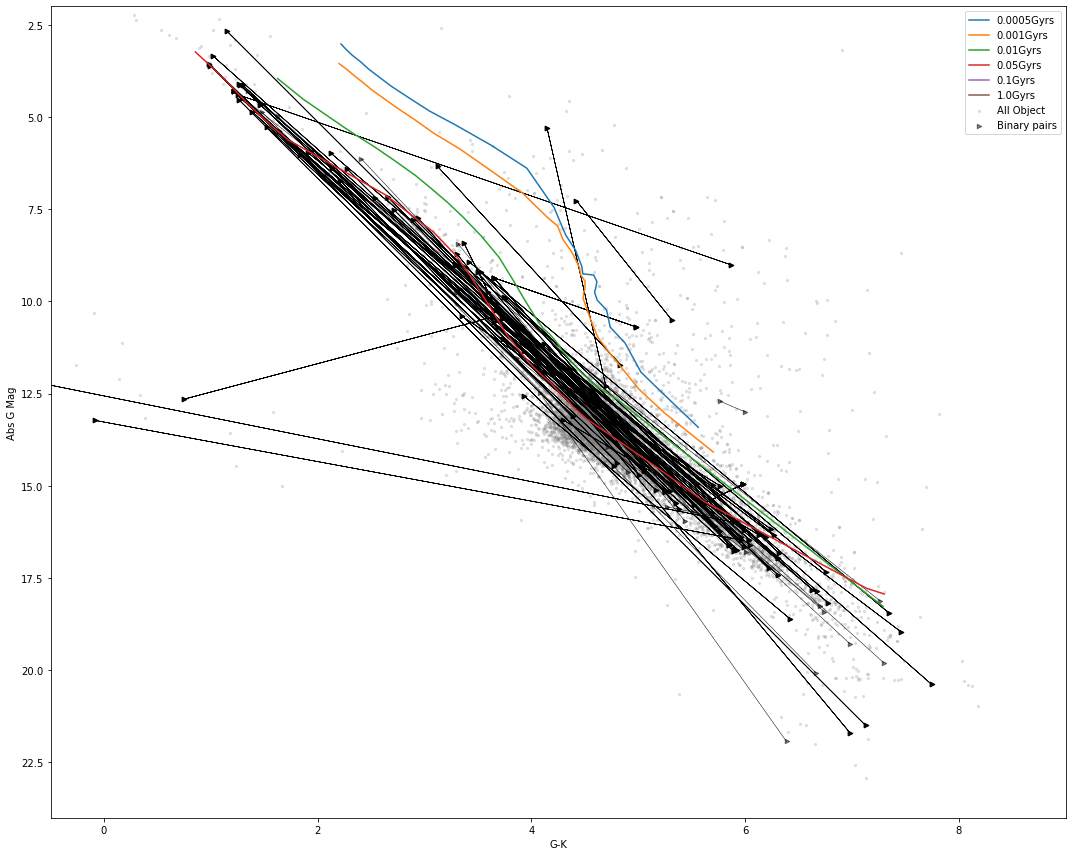

In [45]:
fig,ax = plt.subplots(1,1,figsize=(15,12))
tbasic = basic[basic['G_K'] < 10]
df_secondary = only_secondary[only_secondary['G_K']<10]
ax.scatter(cone['G_K'], cone['ABSmag'], color = 'grey', alpha = 0.2, s= 5, label= 'All Object')

ages = [0.0005, 0.001, 0.01,0.05,0.1, 1.0]

for i in range(len(tbasic)):
    absG =[]
    G_R = []
    sec_obj = Converttolist(tbasic.iloc[i]['COMPANIONS'])
    for j in range(len(df_secondary)):
        if df_secondary.iloc[j]['SHORTNAME'].strip() in sec_obj:
            absG.append(tbasic.iloc[i]['ABSmag'])
            absG.append(df_secondary.iloc[j]['ABSmag'])
            G_R.append(tbasic.iloc[i]['G_K'])
            G_R.append(df_secondary.iloc[j]['G_K'])
    ax.plot(G_R, absG, color = 'black',linestyle = '-', linewidth = 0.5)
    ax.scatter(G_R,absG, marker = '>',color= 'black', alpha = 0.5, s = 20, label= "Binary pairs")

for age in ages:
    gaia_age = gaia[gaia['t(Gyrs)'] == age]
    gaia_age = gaia_age.drop(['t(Gyrs)'], axis = 1)
    tmass_age = tmass[tmass['t(Gyrs)'] == age]
    tmass_age = tmass_age.drop(['t(Gyrs)'], axis = 1)
    data = gaia_age.join(tmass_age.set_index("M/Ms"), on= 'M/Ms')
    data = data.dropna()
    data['G_K'] = data['G']- data['Mk'] 
    ax.plot(data['G_K'], data['G'], label = f'{age}Gyrs')
    

ax.set_xlabel("G-K")
ax.set_ylabel("Abs G Mag")
ax.set_xlim(-0.50, 9)
ax.set_ylim(2,24)
ax.invert_yaxis()   
handles, labels = ax.get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels, loc='best')
plt.tight_layout()
plt.savefig('all_known_binaries.png')
plt.show()

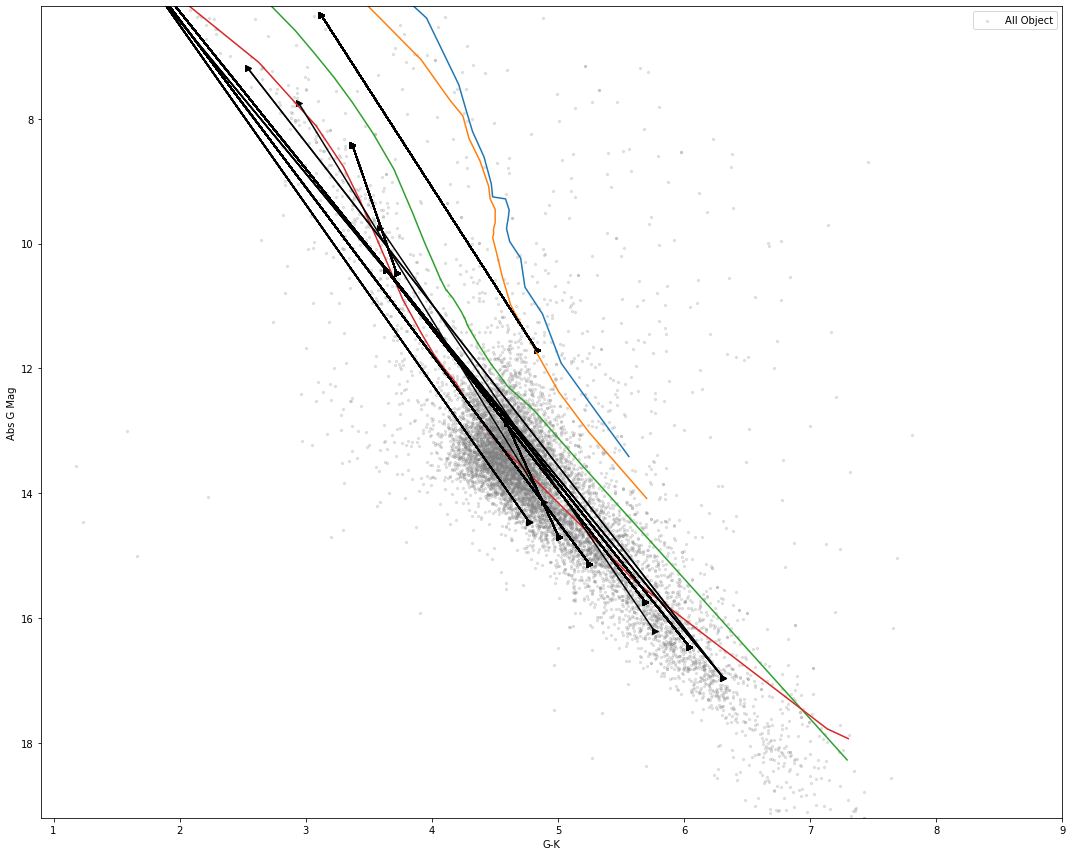

In [43]:
fig,ax = plt.subplots(1,1,figsize=(15,12))



cone = cone[cone['TMASSK']>0]
ax.scatter(cone['G_K'], cone['ABSmag'], color = 'grey', alpha = 0.2, s= 5, label= 'All Object')


ages = [0.0005, 0.001, 0.01,0.05,0.1, 1.0]

for age in ages:
    gaia_age = gaia[gaia['t(Gyrs)'] == age]
    gaia_age = gaia_age.drop(['t(Gyrs)'], axis = 1)
    tmass_age = tmass[tmass['t(Gyrs)'] == age]
    tmass_age = tmass_age.drop(['t(Gyrs)'], axis = 1)
    data = gaia_age.join(tmass_age.set_index("M/Ms"), on= 'M/Ms')
    data = data.dropna()
    data['G_K'] = data['G']- data['Mk'] 
    ax.plot(data['G_K'], data['G'])

for i in range(len(pri)):
    gk =[]
    g= []
    sec_obj = fxn.Converttolist(pri.iloc[i]['COMPANIONS'])
    for j in range(len(sec)):
        if sec.iloc[j]['SHORTNAME'].strip() in sec_obj:
            gk.append(sec.iloc[j]["G_K"])
            gk.append(pri.iloc[j]["G_K"])
            g.append(sec.iloc[j]["ABSmag"])
            g.append(pri.iloc[j]["ABSmag"])
    ax.plot(gk, g, color = 'black', linestyle ='-')
    ax.scatter(gk,g, marker= ">", color ='black')




ax.set_xlabel("G-K")
ax.set_ylabel("Abs G Mag")
ax.set_xlim(0.90, 9)
ax.set_ylim(6.2,19.2 )
ax.invert_yaxis()   
handles, labels = ax.get_legend_handles_labels()
handles, labels = ax.get_legend_handles_labels()
labels, ids = np.unique(labels, return_index=True)
handles = [handles[i] for i in ids]
plt.legend(handles, labels, loc='best')
plt.tight_layout()
plt.savefig("known_binary.png")
plt.show()